## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# LOAD DATA AND CHECK FEW ROWS
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# NUMBER OF ROWS IN THE DATASET
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# NUMBER OF UNIQUE USERS IN THE DATASET
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
# AVERAGE OF USERS CONVERTED
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# NUMBER OF TIMES THE new_page AND treatment DO NOT LINE UP
# GROUP 1 = times treatment group goes to old page
# GROUP 2 = times control group goes to new page
group_1 = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
group_2 = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]

discrepancy = len(group_1) + len(group_2)
discrepancy

3893

f. Do any of the rows have missing values?

In [7]:
# CHECK FOR MISSING VALs
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# COPY OF df
df2 = df

# MISMATCH treatment group
df2.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)

# MISMATCH control group
df2.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
# NUMBERS OF UNIQUE user_ids IN df2
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# NUMBER OF DUPLICATE user_id IN df2
df2['user_id'].duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [12]:
# ROW INFO FOR THE DUPLICATED user_id
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# REMOVE DUPLICATE VALUE
df2=df2.drop_duplicates("user_id")

In [14]:
# CHECK FOR REPEATED user_id IN df2
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
# AVERAGE OF NA INDIVIDUAL CONVERTING REGARDLESS OG THE PAGE THEY LAND
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# PROBABILITY THAT control group CONVERTED
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
# PROBABILITY THAT treatment group CONVERTED
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
# PROBABILITY THAT AN INDIVIDUAL RECEIVED THE new page
df2['landing_page'].value_counts()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**I would not say that the new treatment page leads to more converstions due the very small differents between the probability of an individual that received the new page and the probability of an individual that was in treatement. The performance of both page are similars. There is not evidence enought that supports that statement.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ : $p_{new}$ <= $p_{old}$**

**$H_{1}$ : $p_{new}$ > $p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# CONVERTION RATE FOR new page
p_new = df2[df2['landing_page'] == 'new_page']['converted'].mean()
p_new

0.11880806551510564

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
# CONVERTION RATE FOR old page
p_old = df2[df2['landing_page'] == 'old_page']['converted'].mean()
p_old

0.1203863045004612

c. What is $n_{new}$?

In [21]:
# NUMBER OF INDIVIDUALS IN treatment GROUP
n_new = len(df2[df2['group'] == 'treatment'])
n_new

145310

d. What is $n_{old}$?

In [22]:
# NUMBER OF INDIVIDUALS IN control GROUP
n_old = len(df2[df2['group'] == 'control'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
p_mean = np.mean([p_new, p_old])

In [24]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])
new_page_converted.mean()

0.11972335007914114

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])
old_page_converted.mean()

0.12045513994245358

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#new_page_converted - old_page_converted
#new_page_converted/n_new - old_page_converted/n_old
#new_page_converted[:145274]/n_new - old_page_converted/n_old
new_page_converted.mean()-old_page_converted.mean()

-0.000731789863312432

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# SIMULATION 10K TIMES
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])
    p_diff = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

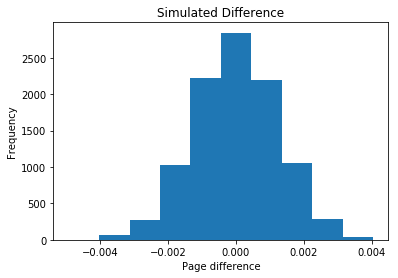

In [30]:
# HISTOGRAM
plt.hist(p_diffs)
plt.title('Simulated Difference')
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# FIND THE DIFF BY SUBTRACTING [treatment group][converted].mean - [control group][converted].mean()
# p_diffs TO np.array
# FINALLY diff < p_diffs AVERAGE
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
p_diffs = np.array(p_diffs)
(act_diff < p_diffs).mean()

0.9044

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j, it was computed the p value or calculated probability. It is the probability of finding the observed, or more extreme, results when the null hypothesis (H 0) of a study question is true. It means that Null Hypothesis is true and both pages provide are almost similars. Old page is better.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [33]:
from scipy.stats import norm
# TELL US HOW SIGNIFICANT OUR z-score is
norm.cdf(z_score)

0.9050583127590245

In [34]:
# TELL US WHAT OUR CRITICAL VALUE AT 95% CONFIDENCE IS
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The computed z-value and p-value mean that we accept the Null Hypothesis and that the old page is better than the new page. Yes, they do agree with the results in j and k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The type of regression that should be used is Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# ADDING INTERCEPT & CREATING DUMMIES
df['intercept']=1
df[['control', 'treatment']] = pd.get_dummies(df['group'])

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
import statsmodels.api as sm
logit = sm.Logit(df['converted'],df[['intercept','treatment']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Oct 2018   Pseudo R-squ.:               8.085e-06
Time:                        08:46:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value is equal to 0.19 (0.19 > 0.05). In the regression model, we test for not equal in our hypotheses and in Part II we tested for greater than or equal. Part II was one sided and in our regression model is used to test the two-sided hypothesis.**

**$H_{0}$ : $p_{new}$ - $p_{old}$ = 0**

**$H_{1}$ : $p_{new}$ - $p_{old}$ != 0**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is good idea to consider other factors to add into the regression model because it will provide us with a true model for the entire population. It will also allow us to draw more accurate conclusions about a larger popualtion from a random sample. For example, a real state agent will be able to fing the size of the homes and the number of bedrooms have a strong correlation to the price of a home. In the case of our dataset, considering the season in the country could be a factor.
By adding additional terms into the regression model can cause the regression coefficients, p-values, and r-squared to be misleading.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [39]:
### DUMMIES VAR
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
### FIT LINEAR MODEL AND DISPLAY SUMMARY
df['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Oct 2018   Pseudo R-squ.:                 -0.2214
Time:                        09:05:37   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

In [41]:
np.exp(results.params)

CA    0.130350
US    0.135779
dtype: float64

In [42]:
1/_

CA    7.671651
US    7.364925
dtype: float64

<a id='conclusions'></a>
## Conclusions

The results in this logistic regression suggest that we accept the Null Hypothesis and reject the Alternative Hypothesis. Test results in the analysis above showed that there is a tiny difference between the convertion rates for both groups (treatment and control). Due the lack of evidence, we shouldn't reject the Null Hypothesis. By looking at the histogram, we noticed that the new page doesn't performece as well as the old page. After merging our original dataset with the country dataset, we noticed that regarless of where the individual is living they have a 50% chance to land on any of the pages leaving out that this was not dependent in the countries.

I would suggest that the e-commerce company to keep and to put work on the enhancement of the old page.